In [1]:
import scanpy as sc
import numpy as np
import sctm
import squidpy as sq
import sklearn
import seaborn as sns

%load_ext autoreload
%autoreload 2

/home/chengwei/miniconda3/envs/torch/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/home/chengwei/miniconda3/envs/torch/lib/python3.9/site-packages/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()


In this tutorial, we demonstrate how to analyse multiple tissue slices in horizontal integration. Here we take mouse anterior and posterior brain as example. ST data were downloaded from https://www.10xgenomics.com/. The two slices are aligned for visual purposes

The prepocessed data can be accessible and downloaded via https://zenodo.org/records/10988053.

In [2]:
adata = sc.read_h5ad(
    "../../../../STAMP/Reproducibility/ProcessedData/Visium_Mousebrain/adata_benchmark.h5ad"
)
adata.var_names_make_unique()

In [3]:
sc.pp.calculate_qc_metrics(adata, inplace=True)
adata.layers["counts"] = adata.X.copy()

In [4]:
sq.gr.spatial_neighbors(adata, library_key="data")

In [ ]:
sctm.seed.seed_everything(5)
model = sctm.stamp.STAMP(
    adata[:, adata.var.highly_variable],
    n_topics=n_topics,
    layer = "counts",
    categorical_covariate_keys = ["data"],
    gene_likelihood = "nb")

model.train(learning_rate = 0.01, min_epochs = 200)

topic_prop = model.get_cell_by_topic()
beta = model.get_feature_by_topic()
for i in topic_prop.columns:
    adata.obs[i] = topic_prop[i]

In [44]:
topic_prop = model.get_cell_by_topic()
beta = model.get_feature_by_topic(pseudocount = 0.0)
for i in topic_prop.columns:
    adata.obs[i] = topic_prop[i]

top_genes = []
for i in topic_prop.columns:
    top_genes += beta.nlargest(1, i).index.tolist()

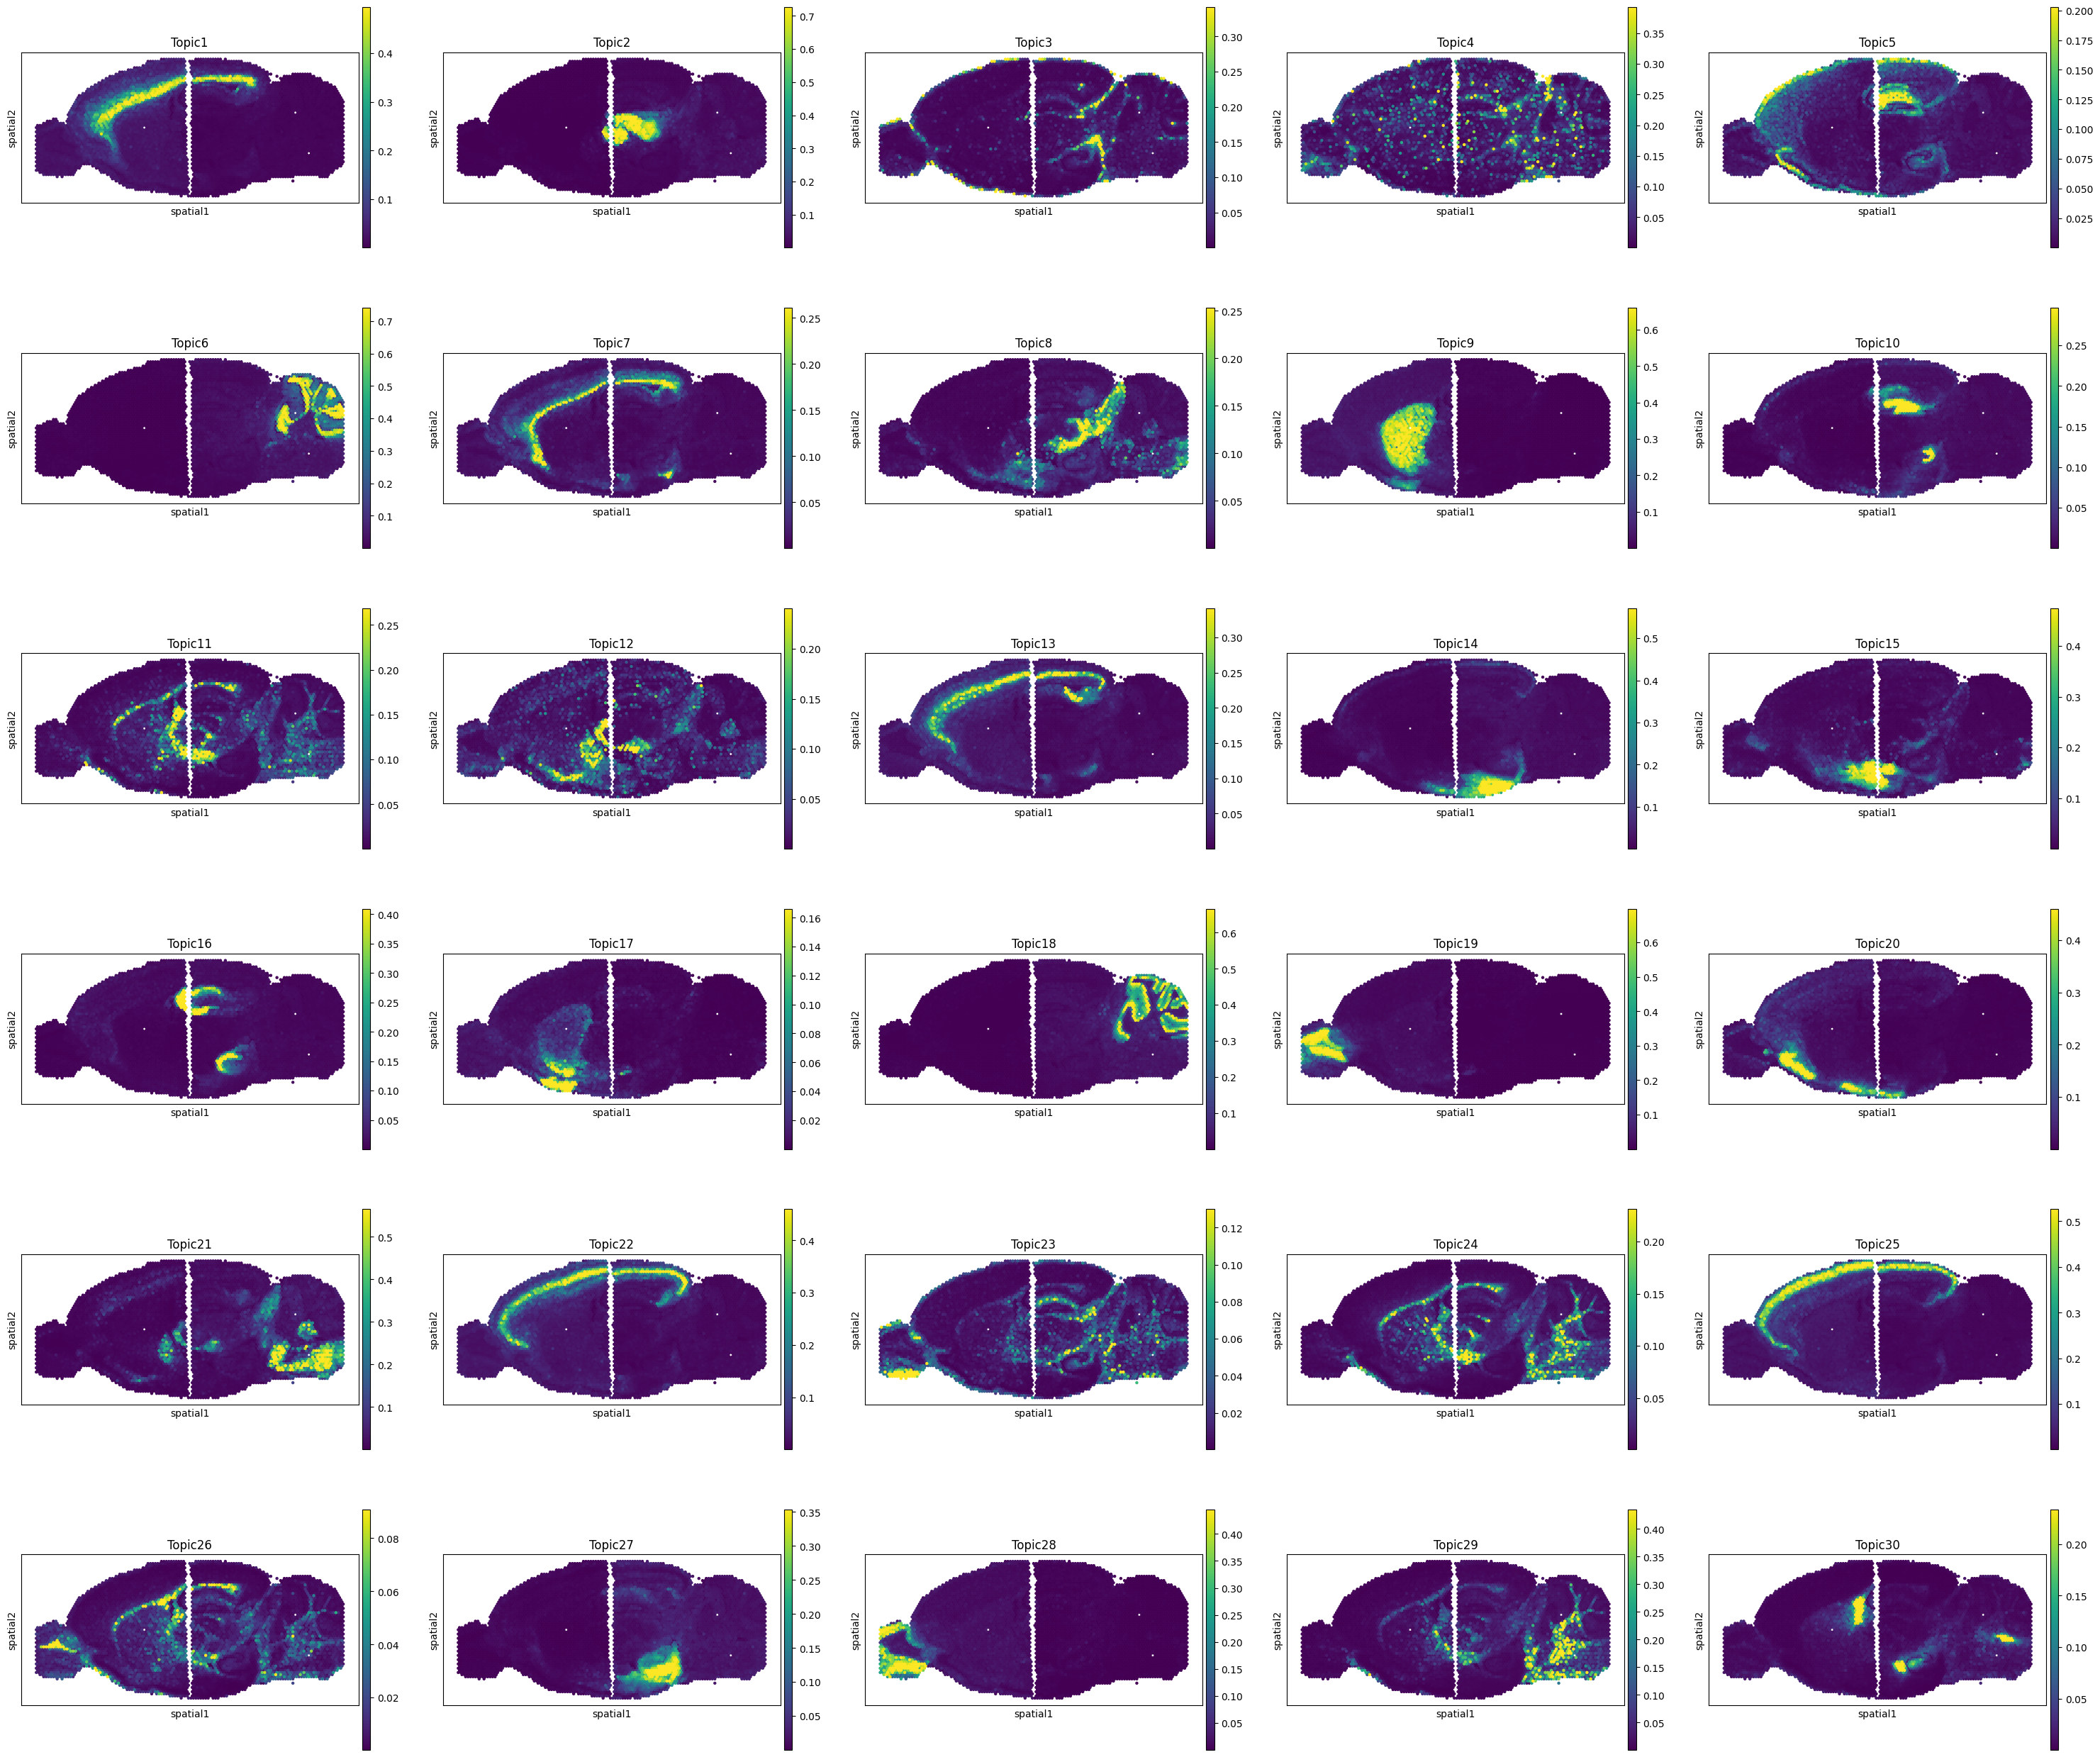

In [45]:
sctm.pl.spatial(adata, color=topic_prop.columns, ncols=5, size=40, vmax="p99")

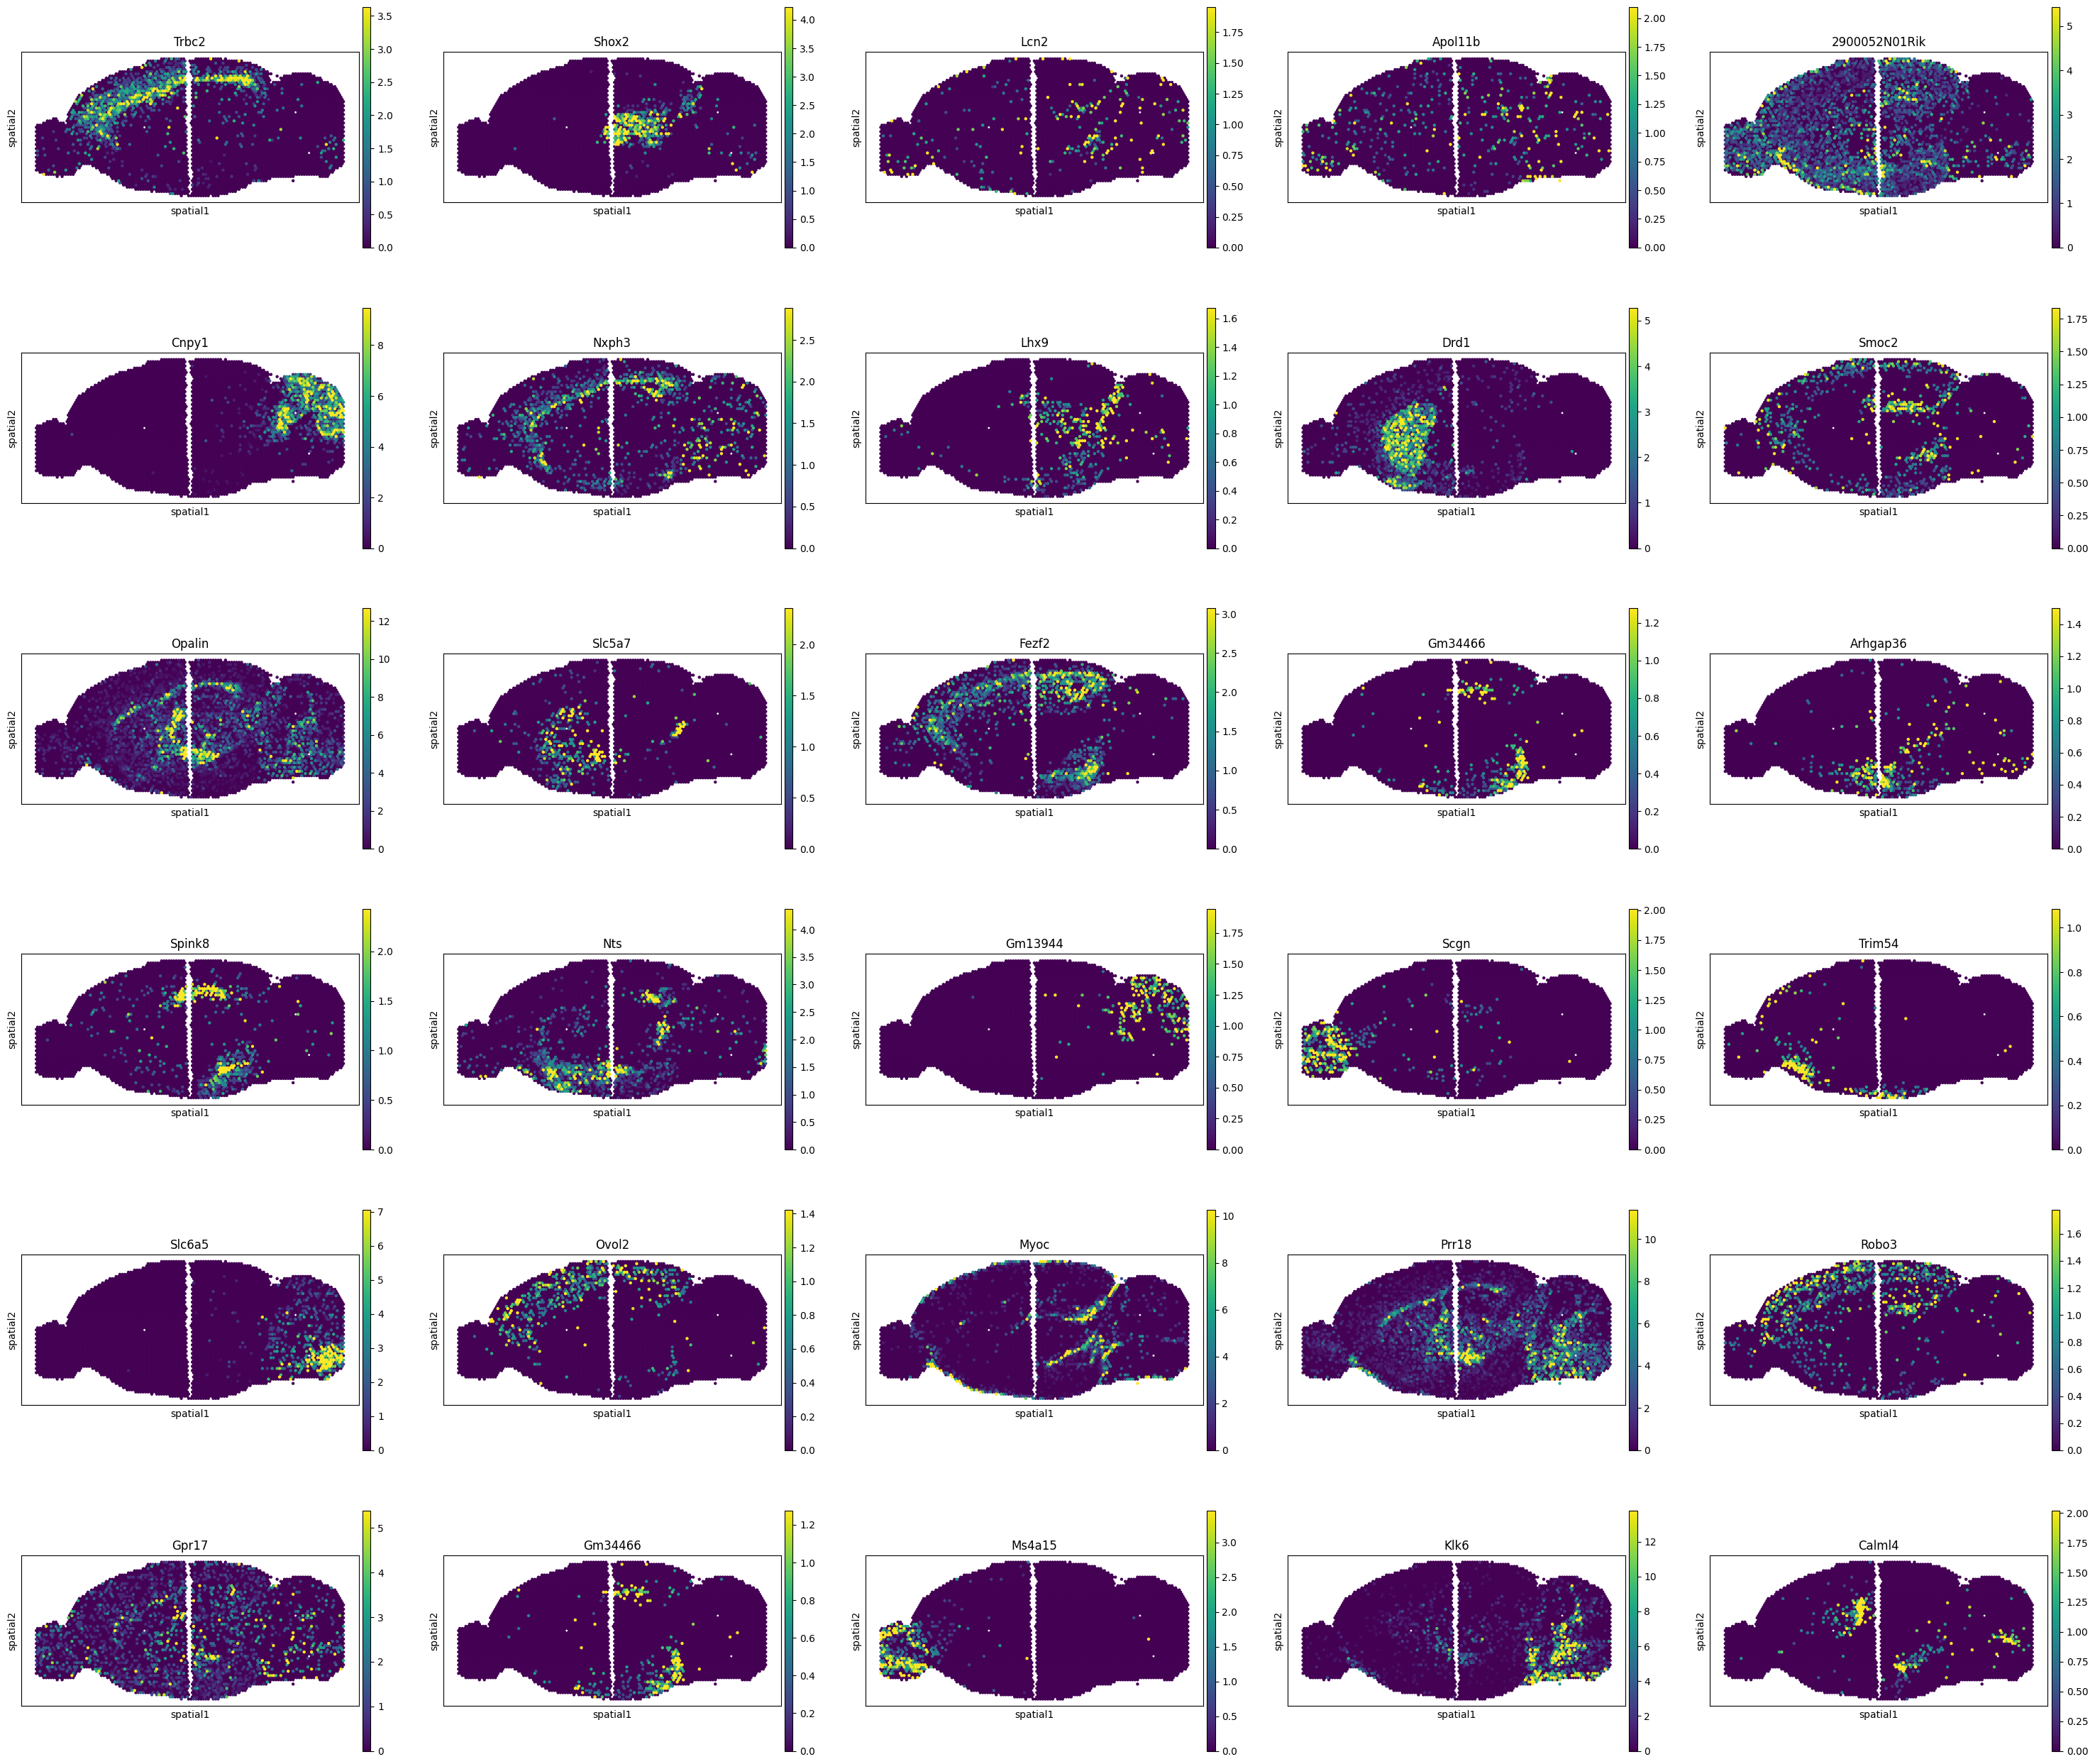

In [46]:
sctm.pl.spatial(adata, color=top_genes, ncols=5, size=40, vmax="p99")

Plot out the different layers (Cell2location plots)

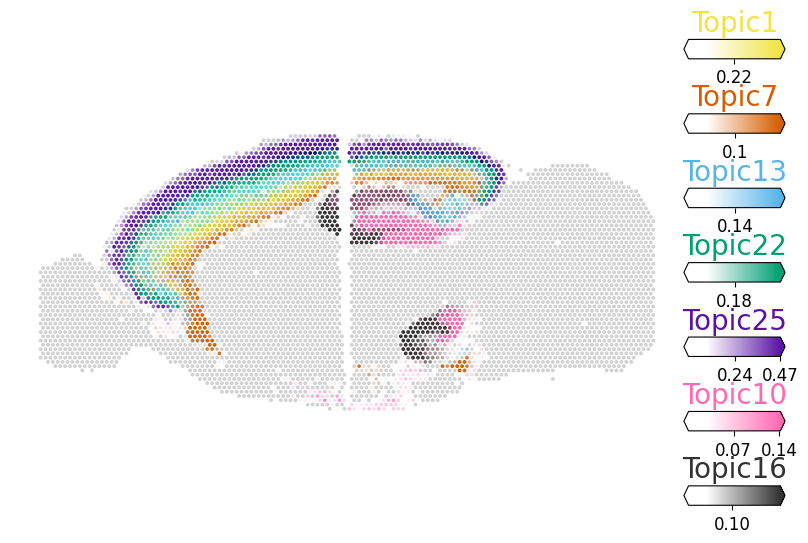

In [47]:
topics = ["Topic1", "Topic7", "Topic13", "Topic22", "Topic25", "Topic10", "Topic16"]
fig = sctm.pl.plot_spatial(
    adata,
    topic_prop.loc[:, topics],
    spot_size=7,
    display_zeros=True,
    axis_y_flipped=True,
)